<h1 align=center><font size=5>Chronic Kidney Disease (CKD)</font></h1>

## Predictive Model <a id = 'stats_func'></a> (by RNN Networks)

### Using the medications and the start and end day of the prescriptions<a id = 'avg_measure'></a>

#### Path

The path to the current opened notebook.

In [3]:
import os
os.getcwd()
#os.chdir('../../../Desktop/Lucas_PostDoc/')
#os.getcwd()

'C:\\Users\\jetin\\Desktop\\Holmusk_Interview'

#### Packages needed

The packages is loaded which will be useful in the analysis.

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.layers import LSTM, Input,  Reshape, Dropout, Activation
from keras.layers import SimpleRNN
from keras.models import Model
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from cwrnn import ClockworkRNN

#### Data File loaded

The data file containing the medications, daily dosage, the start and end day of the prescription. The information in the file is displayed.

In [6]:
nRowsRead = 3000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('./dataScienceTask/T_meds.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'T_meds.csv'
nRow_tn, nCol_tn = df.shape
print("----------------------------------------------------")
print(f'There are {nRow_tn} rows and {nCol_tn} columns for creatinine')
print(df['drug'].value_counts())
print(df.describe())
print("----------------------------------------------------")

----------------------------------------------------
There are 2181 rows and 5 columns for creatinine
metformin        482
atorvastatin     357
simvastatin      258
losartan         251
metoprolol       211
valsartan        110
atenolol         104
rosuvastatin     103
pravastatin      100
carvedilol        57
lovastatin        47
olmesartan        33
bisoprolol        13
irbesartan        11
propranolol       11
canagliflozin      7
telmisartan        7
nebivolol          7
labetalol          5
pitavastatin       4
dapagliflozin      3
Name: drug, dtype: int64
                id  daily_dosage    start_day      end_day
count  2181.000000   2181.000000  2181.000000  2181.000000
mean    144.054562    276.653141   291.254470   370.996332
std      87.194538    478.411077   191.087155   190.575803
min       0.000000      2.000000   -78.000000    -4.000000
25%      68.000000     20.000000   126.000000   208.000000
50%     140.000000     50.000000   290.000000   377.000000
75%     222.000000 

#### Data File loaded

The data file containing the longitudinal data of lab measurements and its time is loaded here and the information in the file is displayed.

In [7]:
nRowsRead = 1000
df1 = pd.read_csv('./dataScienceTask/T_stage.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'T_stage.csv'
nRow_tn, nCol_tn = df1.shape
print("----------------------------------------------------")
print(f'There are {nRow_tn} rows and {nCol_tn} columns for stage progress')
print(df1['Stage_Progress'].value_counts())
print("----------------------------------------------------")

----------------------------------------------------
There are 300 rows and 2 columns for stage progress
False    200
True     100
Name: Stage_Progress, dtype: int64
----------------------------------------------------


#### Matrix consisting of the medications, daily dosage and start and end day of the prescription.

A matrix consisting of the medications, its daily dosage, start and end day of the prescription for each person along the row of this matrix.

In [17]:
print(df['drug'].unique())
print("------------------------------------------------------------")
print("Number of unique drugs given in total : ", df['drug'].nunique())
print("------------------------------------------------------------")

tot_persons = 300

list_drug = df['drug']
names_drug = list_drug.unique()
dict_drug = {}
ind = 0

for drug in list_drug.unique():
    dict_drug[names_drug[ind]] = ind
    ind = ind+1

print(dict_drug)    
print("------------------------------------------------------------")

meds_list = np.zeros((tot_persons, 4*len(names_drug)*18))

for person in range(0,tot_persons): 
    list1 = df.index[df['id'] == person].tolist()
    list2 = list_drug[list1]
    #print(list2)
    ind=0
    ind1=1
    for index in list1:
        if (ind==0) or (dict_drug[list_drug[index]]!=dict_drug[list_drug[index-1]]):
            meds_list[person][4*dict_drug[list_drug[index]]] = dict_drug[list_drug[index]]+1
            meds_list[person][4*dict_drug[list_drug[index]]+1] = df['daily_dosage'][index]
            meds_list[person][4*dict_drug[list_drug[index]]+2] = df['start_day'][index]
            meds_list[person][4*dict_drug[list_drug[index]]+3] = df['end_day'][index]
            if (ind!=0) and (dict_drug[list_drug[index]]!=dict_drug[list_drug[index-1]]):
                ind1=1
            
        if (ind!=0) and (dict_drug[list_drug[index]]==dict_drug[list_drug[index-1]]):    
            meds_list[person][4*len(names_drug)*ind1+4*dict_drug[list_drug[index]]] = dict_drug[list_drug[index]]+1
            meds_list[person][4*len(names_drug)*ind1+4*dict_drug[list_drug[index]]+1] = df['daily_dosage'][index]
            meds_list[person][4*len(names_drug)*ind1+4*dict_drug[list_drug[index]]+2] = df['start_day'][index]
            meds_list[person][4*len(names_drug)*ind1+4*dict_drug[list_drug[index]]+3] = df['end_day'][index]
            ind1=ind1+1
        ind=ind+1
            
#print(meds_list[298][0:4*21*8])   
data = meds_list

S = np.sum(data,0)
S_index = np.where(S == 0)
#print(S)
print(S_index)
print("------------------------------------------------------------")
data = np.delete(data,S_index,1)
print(data)
print("------------------------------------------------------------")
S = np.sum(data,0)
S_index = np.where(S == 0)
#print(S)
#print(S_index)

['atorvastatin' 'losartan' 'metformin' 'rosuvastatin' 'pravastatin'
 'carvedilol' 'valsartan' 'metoprolol' 'simvastatin' 'bisoprolol'
 'atenolol' 'lovastatin' 'olmesartan' 'irbesartan' 'canagliflozin'
 'dapagliflozin' 'telmisartan' 'labetalol' 'nebivolol' 'pitavastatin'
 'propranolol']
------------------------------------------------------------
Number of unique drugs given in total :  21
------------------------------------------------------------
{'atorvastatin': 0, 'losartan': 1, 'metformin': 2, 'rosuvastatin': 3, 'pravastatin': 4, 'carvedilol': 5, 'valsartan': 6, 'metoprolol': 7, 'simvastatin': 8, 'bisoprolol': 9, 'atenolol': 10, 'lovastatin': 11, 'olmesartan': 12, 'irbesartan': 13, 'canagliflozin': 14, 'dapagliflozin': 15, 'telmisartan': 16, 'labetalol': 17, 'nebivolol': 18, 'pitavastatin': 19, 'propranolol': 20}
------------------------------------------------------------
(array([ 228,  229,  230,  231,  308,  309,  310,  311,  312,  313,  314,
        315,  328,  329,  330,  331

#### Standardization of the data along the row

The data is standardized using StandardScaler or MinMaxScaler along the row before inputting the data into the neural network.

In [10]:
scaler = StandardScaler().fit(data.T)

A = scaler.transform(data.T)

data = A.T
print("------------------------------------------------------------")
print(data.shape)
print("------------------------------------------------------------")
print(data[0])
print("------------------------------------------------------------")

------------------------------------------------------------
(300, 648)
------------------------------------------------------------
[-0.16809628 -0.09184103 -0.01558578  0.74696674 -0.15962348  0.67071149
 -0.01558578  2.27207177 -0.15115067  8.29623665 -0.01558578  0.74696674
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909
 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.17656909 -0.

#### Splitting and preprocessing the Matrix

The constructed matrix from the medications and other informations of the prescription is split into training and testing input set.   
Similarly, the data on the patient will progress in CKD or not is converted to 1 and 0 respectively and then the data is split into training and testing output set.

In [11]:
labels=data
features = df1[['Stage_Progress']].astype(np.float32)

#one_hot_encoded_data = pd.get_dummies(df8[['Stage_Progress']], columns = ['Stage_Progress'])
#print(one_hot_encoded_data)

#features = one_hot_encoded_data.astype(np.float32)



X_train, X_test, y_train, y_test = train_test_split(labels, features, test_size=0.1, random_state=42) 

print("------------------------------------------------------------")
print(y_test)
print("------------------------------------------------------------")

------------------------------------------------------------
     Stage_Progress
203             0.0
266             0.0
152             0.0
9               0.0
233             0.0
226             0.0
196             0.0
109             1.0
5               0.0
175             0.0
237             1.0
57              1.0
218             1.0
45              1.0
182             1.0
221             1.0
289             0.0
211             0.0
148             0.0
165             1.0
78              0.0
113             1.0
249             0.0
250             0.0
104             1.0
42              1.0
281             1.0
295             1.0
157             0.0
238             0.0
------------------------------------------------------------


#### Standardization of the data

The data is standardized using StandardScaler or MinMaxScaler before inputting the data into the neural network.

In [12]:
scaler = StandardScaler().fit(X_train)

A = scaler.transform(X_train)

B = scaler.transform(X_test)  

X_train = A

X_test = B

# X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print("------------------------------------------------------------")
print(X_train)
print("------------------------------------------------------------")

------------------------------------------------------------
[[-0.99958519 -0.04405739  0.373307   ... -0.27999323 -0.44487116
  -0.42668796]
 [ 0.00577688  1.00421057  1.54459005 ... -0.08936928 -0.10931505
  -0.10718167]
 [ 0.91269327 -0.28667474 -0.36454311 ...  0.14243378  0.29872882
   0.28134524]
 ...
 [ 0.37038653 -0.36780927 -0.37776427 ...  0.03325602  0.10654277
   0.09835155]
 [ 0.33993985 -0.3723644  -0.37850655 ...  0.02712646  0.09575288
   0.08807775]
 [ 0.55441744  0.1669135  -0.38246085 ... -0.00552738  0.03827218
   0.03334638]]
------------------------------------------------------------


#### Reshaping the input training and testing set

The input training and testing set is reshaped from two to three dimensional matrix for inputting to the CNN neural networks.

In [13]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_train = np.array(X_train, dtype = float)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1)) 
X_test = np.array(X_test, dtype = float)
print(X_train.shape)
print(X_test.shape)

(270, 648, 1)
(30, 648, 1)


#### Neural Network 5 (Simple RNN and LSTM)

The basic architecture of neural network based on Simple RNN and LSTM. 

In [18]:
print("------------------------------------------------------------")
#RNN Model
model = Sequential()
model.add(SimpleRNN((1),batch_input_shape=(None,X_train.shape[1],1),return_sequences=True))
model.add(SimpleRNN((1),batch_input_shape=(None,None,1),return_sequences=True))
#model.add(SimpleRNN((48),batch_input_shape=(None,None,1),return_sequences=False))
model.add(LSTM((100),dropout = 0.2, batch_input_shape=(None,None,1),return_sequences=False))
#model.add(LSTM((48),batch_input_shape=(None,None,1),return_sequences=True))
#model.add(LSTM((48),batch_input_shape=(None,None,1),return_sequences=False))
#model.add(LSTM((48),return_sequences=False))
#opt = keras.optimizers.Adam()
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
print("------------------------------------------------------------")

------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 648, 1)            3         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 648, 1)            3         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 142,807
Trainable params: 142,807
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------


#### Compiling the Neural Network 5

The compilation of the neural network using loss function as binary crossentropy, optimizer as adam and using accuracy as metric to test the performance of the network.

In [20]:
print("------------------------------------------------------------")
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])

model.fit(X_train,y_train,epochs=20, validation_split=0.2)
print("------------------------------------------------------------")

------------------------------------------------------------
Train on 216 samples, validate on 54 samples
Epoch 1/20
216/216 [==============================] - 7s 30ms/step - loss: 0.6537 - acc: 0.6574 - val_loss: 0.5616 - val_acc: 0.7593
Epoch 2/20
216/216 [==============================] - 6s 26ms/step - loss: 0.6498 - acc: 0.6574 - val_loss: 0.5860 - val_acc: 0.7593
Epoch 3/20
216/216 [==============================] - 7s 33ms/step - loss: 0.6474 - acc: 0.6574 - val_loss: 0.5576 - val_acc: 0.7593
Epoch 4/20
216/216 [==============================] - 5s 25ms/step - loss: 0.6565 - acc: 0.6574 - val_loss: 0.5838 - val_acc: 0.7593
Epoch 5/20
216/216 [==============================] - 5s 24ms/step - loss: 0.6472 - acc: 0.6574 - val_loss: 0.5726 - val_acc: 0.7593
Epoch 6/20
216/216 [==============================] - 5s 23ms/step - loss: 0.6471 - acc: 0.6574 - val_loss: 0.5949 - val_acc: 0.7593
Epoch 7/20
216/216 [==============================] - 5s 24ms/step - loss: 0.6548 - acc: 0.6574 

#### Evaluating the Neural Network 5 on Test set

The trained neural network is evaluated on the test set to check its performance.

-----------------------------------------------------------------
Accuracy of RNN Classifier : 0.5666666666666667
-----------------------------------------------------------------
Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           0       0.57      1.00      0.72        17

    accuracy                           0.57        30
   macro avg       0.28      0.50      0.36        30
weighted avg       0.32      0.57      0.41        30

-----------------------------------------------------------------


C:\Users\jetin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


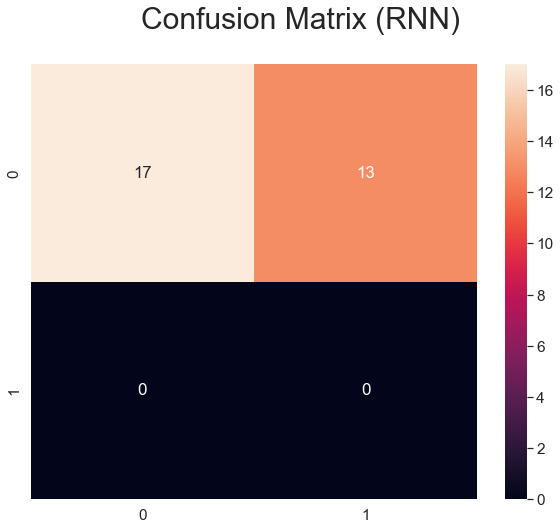

In [21]:
y_pred = model.predict_classes(X_test)
score = model.evaluate(X_test, y_test,verbose=0)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True)
plt.suptitle('Confusion Matrix (RNN)',fontsize=30)
# plt.savefig("./ConfusionMatrix_RNNLSTM_Meds.jpg", 
#            bbox_inches ="tight", 
#            pad_inches = 1, 
#            transparent = True, 
#            orientation ='landscape') 

print("-----------------------------------------------------------------")
print("Accuracy of RNN Classifier :", accuracy_score(y_test, y_pred))
print("-----------------------------------------------------------------")
matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)
print("-----------------------------------------------------------------")

#### Neural Network 6 (Clockwork RNN)

The basic architecture of neural network based on Clockwork RNN. 

In [31]:
print("------------------------------------------------------------")
model = Sequential()
model.add(ClockworkRNN(periods=[1,2,3],
                       units_per_period=10, 
                       input_shape=(None, 1), 
                       output_units=X_train.shape[1]))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
print("------------------------------------------------------------")

------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
clockwork_simple_rnn_3 (Cloc (None, 648)               20748     
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              649000    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1001      
Total params: 670,749
Trainable params: 670,749
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------


#### Compiling the Neural Network 6

The compilation of the neural network using loss function as binary crossentropy, optimizer as adam and using accuracy as metric to test the performance of the network.

In [32]:
print("------------------------------------------------------------")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,epochs=20, validation_split=0.2)
print("------------------------------------------------------------")

------------------------------------------------------------
Train on 216 samples, validate on 54 samples
Epoch 1/20
216/216 [==============================] - 6s 26ms/step - loss: 0.6944 - acc: 0.5833 - val_loss: 0.6140 - val_acc: 0.7778
Epoch 2/20
216/216 [==============================] - 4s 18ms/step - loss: 0.6360 - acc: 0.6667 - val_loss: 0.5923 - val_acc: 0.7778
Epoch 3/20
216/216 [==============================] - 4s 18ms/step - loss: 0.6371 - acc: 0.6898 - val_loss: 0.6549 - val_acc: 0.6852
Epoch 4/20
216/216 [==============================] - 3s 16ms/step - loss: 0.6146 - acc: 0.6852 - val_loss: 0.6468 - val_acc: 0.6481
Epoch 5/20
216/216 [==============================] - 3s 16ms/step - loss: 0.6053 - acc: 0.6759 - val_loss: 0.6583 - val_acc: 0.6667
Epoch 6/20
216/216 [==============================] - 3s 16ms/step - loss: 0.6175 - acc: 0.6759 - val_loss: 0.6405 - val_acc: 0.6852
Epoch 7/20
216/216 [==============================] - 3s 16ms/step - loss: 0.6368 - acc: 0.6389 

#### Evaluating the Neural Network 6 on Test set

The trained neural network is evaluated on the test set to check its performance.

------------------------------------------------------------------
Accuracy of CWRNN Classifier : 0.6
------------------------------------------------------------------
Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.08      0.14        13
           0       0.59      1.00      0.74        17

    accuracy                           0.60        30
   macro avg       0.79      0.54      0.44        30
weighted avg       0.77      0.60      0.48        30

------------------------------------------------------------------


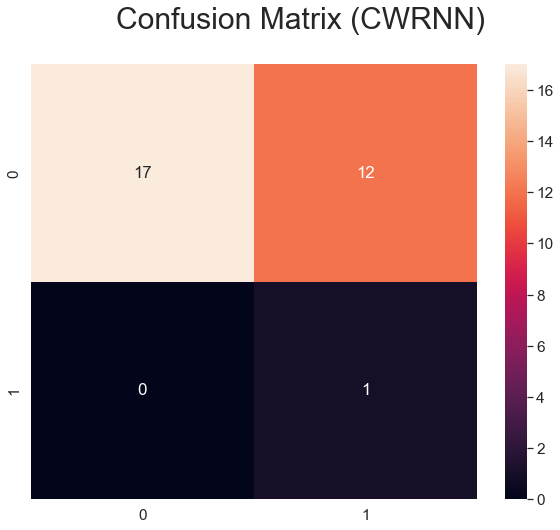

In [33]:
y_pred = model.predict_classes(X_test)
score = model.evaluate(X_test, y_test,verbose=0)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True)
plt.suptitle('Confusion Matrix (CWRNN)',fontsize=30)
# plt.savefig("./ConfusionMatrix_CWRNN_Meds.jpg", 
#            bbox_inches ="tight", 
#            pad_inches = 1, 
#            transparent = True, 
#            orientation ='landscape')
print("------------------------------------------------------------------")
print("Accuracy of CWRNN Classifier :", accuracy_score(y_test, y_pred))
print("------------------------------------------------------------------")
matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)
print("------------------------------------------------------------------")